In [7]:
import scipy.optimize
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import metpy
import scipy.stats as sts
import re
from glob import glob
import warnings
import isca_tools
from isca_tools import cesm
from isca_tools.convection import dry_profile_temp, potential_temp
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig
from isca_tools.utils.base import weighted_RMS
from isca_tools.utils import area_weighting, print_ds_var_list
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.convection.base import lcl_metpy, lapse_moist, moist_profile
from isca_tools.thesis.lapse_theory import get_bulk_lapse_rate, reconstruct_temp, interp_var_at_pressure, \
    get_var_at_plev
from isca_tools.utils.moist_physics import sphum_sat, moist_static_energy
from isca_tools.thesis.adiabat_theory2 import get_scale_factor_theory_numerical, get_temp_adiabat_surf
from isca_tools.thesis.profile_fitting import get_mse_env, get_lnb_lev_ind
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from statsmodels.stats.multitest import fdrcorrection
from tqdm.notebook import tqdm
import scipy
from geocat.comp.interpolation import interp_hybrid_to_pressure
import copy
from typing import Tuple, Optional
import os
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Figure formatting
SMALL_SIZE = 5
MEDIUM_SIZE = 6
BIGGER_SIZE = 7

plt.rc('axes', linewidth=0.5)
plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']

In [3]:
from jobs.theory_lapse.scripts.lcl import ds

2025-10-20 08:11:31 - Start
2025-10-20 08:11:36 - Loaded in Data
2025-10-20 08:11:41 - Computed pressure difference
2025-10-20 08:11:42 - Computed physical LCL


In [4]:
ds['Z_at_lcl'] = get_var_at_plev(ds.Z3, ds.P, ds.p_lcl)
ds['T_at_lcl'] = get_var_at_plev(ds.T, ds.P, ds.p_lcl)

In [124]:
ds_use = ds.sel(lat=3, lon=15, method='nearest')        # Congo
# ds_use = ds.sel(lat=35, lon=100, method='nearest')       # Tibet
ds_use = ds.sel(lat=55, lon=290, method='nearest')      # Large inversion
ds_use = ds.sel(lat=-85, lon=100, method='nearest')     # Antarctica
ds_use = ds.sel(lat=25, lon=50,method='nearest')        # Pursian gulf
# ds_use = ds.sel(lat=28, lon=50, method='nearest')       # Pursian gulf coastline
ds_use = ds.sel(lat=18, lon=0,method='nearest')         # Sahara
ds_use = ds.sel(lat=30, lon=180, method='nearest')      # Ocean
ds_use = ds_use.isel(sample=0)
small = 1
ds_use = ds_use.where(ds_use.P >= ds_use.P.isel(lev=ds_use.lnb_ind) - small)

In [125]:
norm = []
norm_lcl = []
for i in range(ds.lev.size):
    if np.isnan(ds_use.P.values[i]):
        continue
    var = get_mse_env(ds_use.T, ds_use.P, ds_use.Z3, ds_use.T.isel(lev=i), ds_use.P.isel(lev=i), 'full')
    var = var - moist_static_energy(ds_use.T.isel(lev=i), sphum_sat(ds_use.T.isel(lev=i), ds_use.P.isel(lev=i)), ds_use.Z3.isel(lev=i))
    norm.append(weighted_RMS(var, ds_use.P_diff/g, dim='lev'))
    norm_lcl.append(ds_use.P.isel(lev=i))
norm = xr.concat(norm, dim=xr.DataArray(norm_lcl, name='p_lcl', dims='p_lcl'))

In [126]:
norm.p_lcl.isel(p_lcl=norm.argmin())

<xarray.DataArray 'p_lcl' ()> Size: 8B
array(90364.46240918)
Coordinates:
    lat      float64 8B 29.69
    lon      float64 8B 180.0
    sample   int64 8B 1
    p_lcl    float64 8B 9.036e+04

In [131]:
lcl_fine_spacing = 10*100
lcl_fine_search = np.arange(float(norm.p_lcl.isel(p_lcl=norm.argmin()-1)), float(norm.p_lcl.isel(p_lcl=norm.argmin())), lcl_fine_spacing)
lcl_fine_search = np.append(lcl_fine_search,
                            np.arange(float(norm.p_lcl.isel(p_lcl=norm.argmin())),
                                      float(norm.p_lcl.isel(p_lcl=norm.argmin()+1))+lcl_fine_spacing, lcl_fine_spacing))
# lcl_best = float(norm.p_lcl.isel(p_lcl=norm.argmin()))
T_at_lcl_use = interp_hybrid_to_pressure(ds_use.T, ds_use.PS, ds_use.hyam, ds_use.hybm, ds_use.P0,
                                         lcl_fine_search, lev_dim='lev').load()
Z_at_lcl_use = interp_hybrid_to_pressure(ds_use.Z3, ds_use.PS, ds_use.hyam, ds_use.hybm, ds_use.P0,
                                         lcl_fine_search, lev_dim='lev').load()
norm_fine_spacing = []
norm_fine_spacing_lcl = []
for i in range(T_at_lcl_use.plev.size):
    if np.isnan(T_at_lcl_use.values[i]):
        continue
    var = get_mse_env(ds_use.T, ds_use.P, ds_use.Z3, T_at_lcl_use.isel(plev=i), T_at_lcl_use.plev[i], 'full')
    var = var - moist_static_energy(T_at_lcl_use.isel(plev=i), sphum_sat(T_at_lcl_use.isel(plev=i), T_at_lcl_use.plev[i]),
                                    Z_at_lcl_use.isel(plev=i))
    norm_fine_spacing.append(weighted_RMS(var, ds_use.P_diff/g, dim='lev'))
    norm_fine_spacing_lcl.append(float(T_at_lcl_use.plev[i]))
norm_fine_spacing = xr.concat(norm_fine_spacing, dim=xr.DataArray(norm_fine_spacing_lcl, name='p_lcl', dims='p_lcl'))
# norm2 = []
# norm2_lcl = []


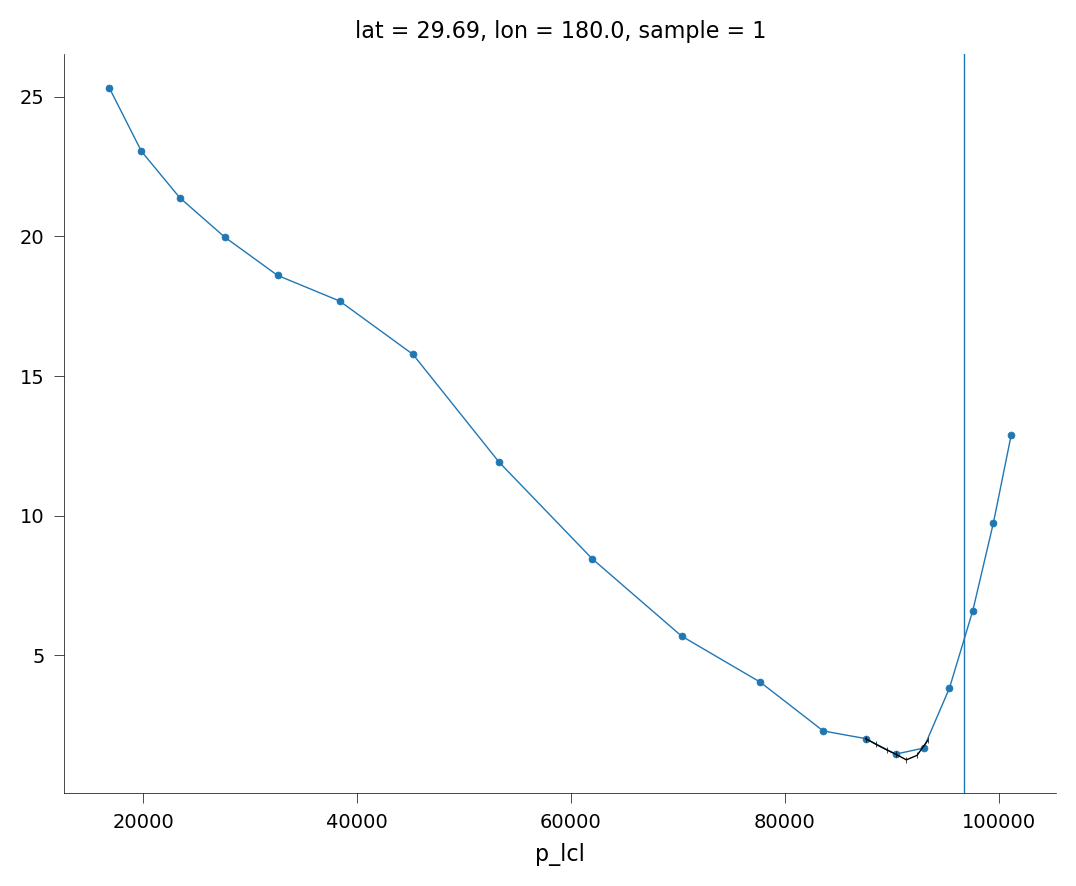

In [132]:
norm.plot(marker='o')
norm_fine_spacing.plot(color='k', marker='|')
plt.gca().axvline(ds_use.p_lcl.isel(lev=-1))
# plt.gca().set_ylim(0, 10)